In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

np.random.seed(42)

NUM_CLASSES = 9
BATCH_SIZE = 32

PATH_TO_TEST_DATASET = "data/CRC-VAL-HE-7K/"

from model import DeepCMorph

In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

In [3]:
torch.backends.cudnn.deterministic = True
device = get_device()

model = DeepCMorph(num_classes=NUM_CLASSES)
model.load_weights(dataset="CRC")

model.to(device)
model.eval()

test_transforms = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.ImageFolder(PATH_TO_TEST_DATASET, transform=test_transforms)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=False, drop_last=False)
TEST_SIZE = len(test_dataloader.dataset)

/Users/dawid/Desktop/uw/rok V/XAI/projekt/DeepCMorph/model.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  missing_keys, unexpected_keys = self.load_state_dict(torch.l

Model loaded, unexpected keys: []


In [4]:
tissue_labels = {
    0: 'adipose',
    1: 'background',
    2: 'debris',
    3: 'lymphocyte',
    4: 'mucus',
    5: 'smooth muscle',
    6: 'normal colon mucosa',
    7: 'cancer-associated stroma',
    8: 'colorectal adenocarcinoma epithelium' # tumor
}

cell_labels = {
    0: 'background',
    1: 'epithelial cell', 
    2: 'connective tissue cell', 
    3: 'lymphocyte', 
    4: 'plasma cell', 
    5: 'neutrophil',  
    6: 'eosinophil'
}

cell_colors = [
    'black',      # background
    'blue',       # epithelial cell
    'green',      # connective tissue cell
    'red',        # lymphocyte
    'yellow',     # plasma cell
    'purple',     # neutrophil
    'orange'      # eosinophil
]

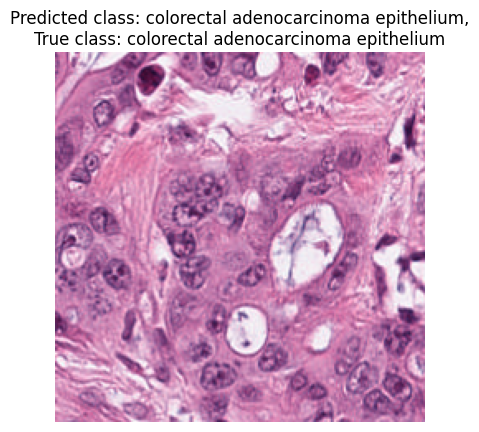

In [6]:
# Plot some examples 
IMG_IDX = 7000
plt.imshow(test_dataset[IMG_IDX][0].permute(1, 2, 0))
prediction = model(test_dataset[IMG_IDX][0].unsqueeze(0).to(device))
predixted_class = prediction.argmax().item()
plt.title(f"Predicted class: {tissue_labels[predixted_class]},\nTrue class: {tissue_labels[test_dataset[IMG_IDX][1]]}")
plt.axis("off")
plt.show()

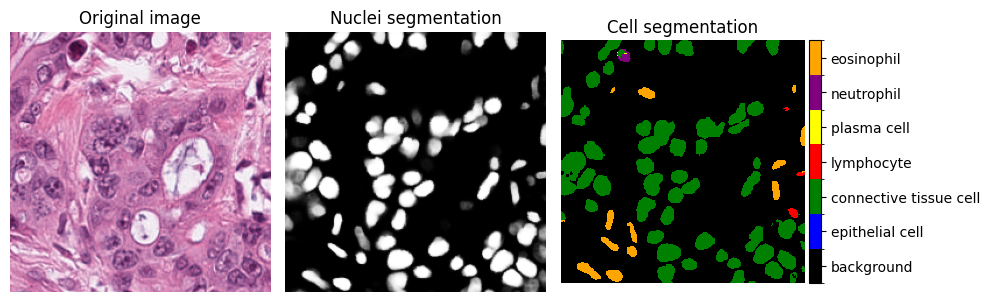

In [7]:
def plot_segmentations(image, model, device, cell_labels, cell_colors, return_plot=False):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title("Original image")
    axs[0].axis("off")

    nuclei_segmentation, cell_segmentation = model(image.unsqueeze(0).to(device), return_segmentation_maps=True)

    axs[1].imshow(nuclei_segmentation.squeeze().cpu().detach().numpy(), cmap="gray")
    axs[1].set_title("Nuclei segmentation")
    axs[1].axis("off")

    cells = torch.argmax(cell_segmentation, dim=1).squeeze().cpu().detach().numpy()
    cmap = ListedColormap(cell_colors)
    bounds = np.arange(-0.5, len(cell_labels) + 0.5, 1)
    norm = BoundaryNorm(bounds, cmap.N)

    im = axs[2].imshow(cells, cmap=cmap, norm=norm, interpolation='none')
    # move cbar ticks to the middle of the color box
    divider = make_axes_locatable(axs[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax, ticks=np.arange(len(cell_labels)), spacing='proportional')
    cbar.ax.set_yticklabels([cell_labels[i] for i in range(len(cell_labels))])

    axs[2].set_title("Cell segmentation")
    axs[2].axis("off")
    if return_plot:
        return fig, axs
    
    plt.tight_layout()
    plt.show()

img = test_dataset[IMG_IDX][0] # 0 is the image, 1 is the label
plot_segmentations(img, model, device, cell_labels, cell_colors)

Rotation: 0 degrees


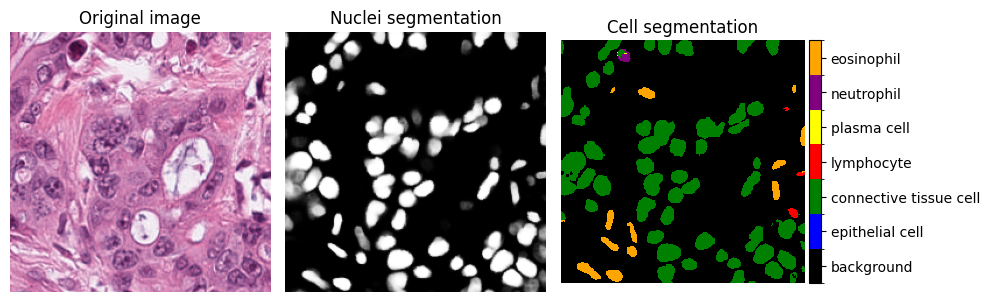

Rotation: 90 degrees


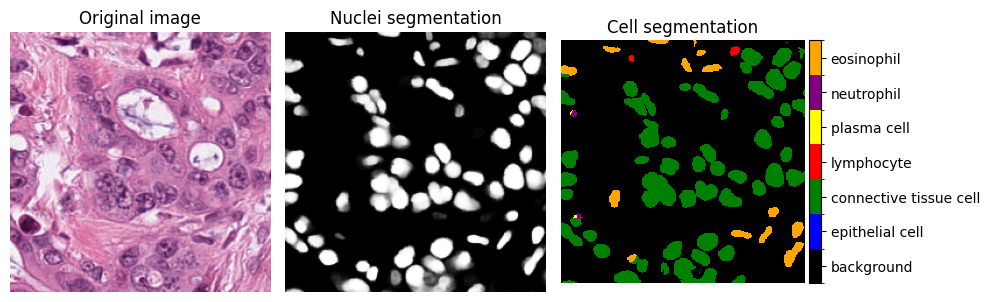

Rotation: 180 degrees


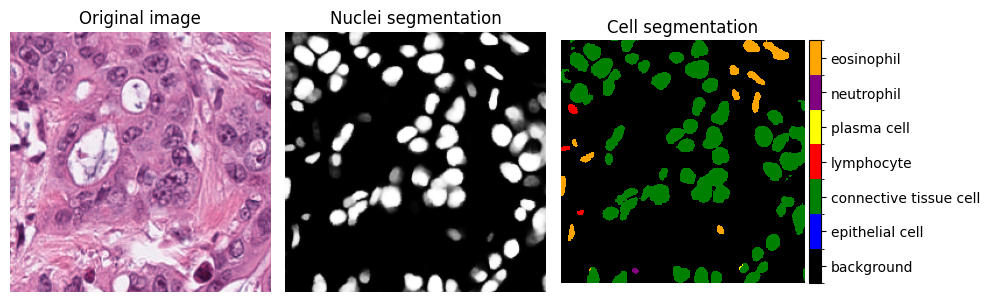

Rotation: 270 degrees


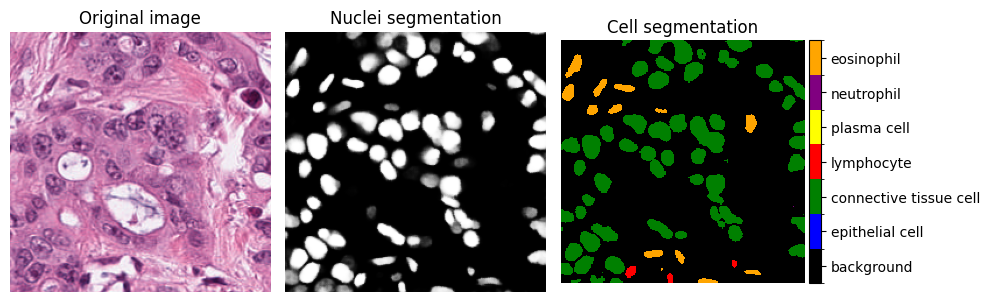

In [7]:
# plot segmentations for all C_4 group rotations (0, 90, 180, 270 degrees)

def rotate_image(image, k):
    """Rotate image by k * 90 degrees."""
    image = torch.rot90(image, k=k, dims=(1, 2))
    return image

for k in range(4):
    img = rotate_image(test_dataset[IMG_IDX][0], k)
    fig, axs = plot_segmentations(img, model, device, cell_labels, cell_colors, return_plot=True)
    print(f"Rotation: {k * 90} degrees")
    fig.tight_layout()
    plt.show()


Superposed segmentations


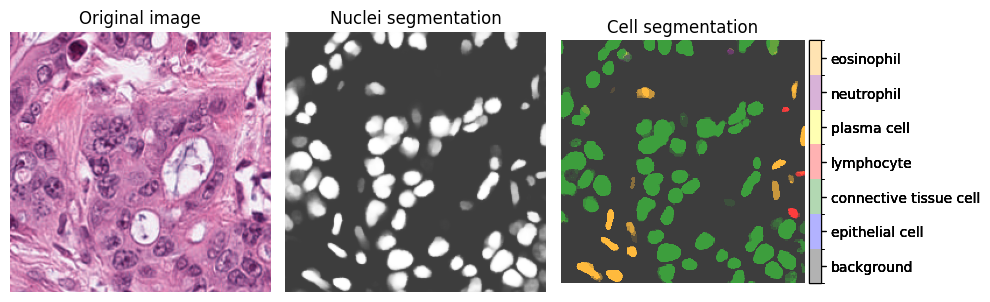

Original segmentation


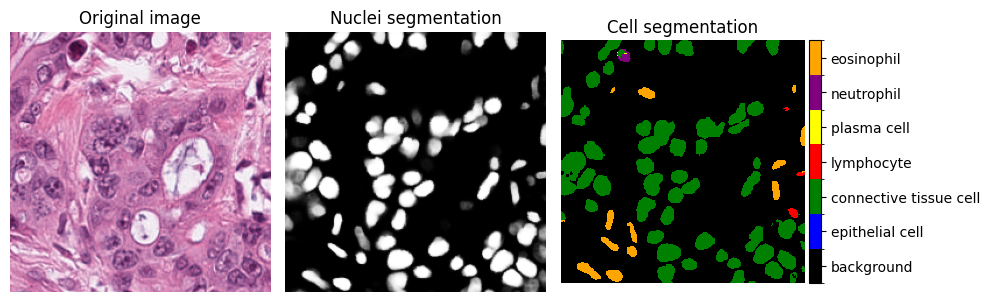

In [8]:
# Superpose segmentations from all rotations

def superpose_segmentations(image, model, device, cell_labels, cell_colors):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title("Original image")
    axs[0].axis("off")

    cmap = ListedColormap(cell_colors)
    bounds = np.arange(-0.5, len(cell_labels) + 0.5, 1)
    norm = BoundaryNorm(bounds, cmap.N)

    nucl_segm, cell_segm = [], []
    for k in range(4):
        img = rotate_image(image, k)
        nuclei_segmentation, cell_segmentation = model(img.unsqueeze(0).to(device), return_segmentation_maps=True)

        rot_back = 4 - k
        rerotated_nuclei = torch.rot90(nuclei_segmentation, k=rot_back, dims=(2, 3))
        rerotated_cells = torch.rot90(cell_segmentation, k=rot_back, dims=(2, 3))

        nucl_segm.append(rerotated_nuclei)
        cell_segm.append(rerotated_cells)

        axs[1].imshow(rerotated_nuclei.squeeze().cpu().detach().numpy(), cmap="gray", alpha=0.3)
        axs[1].set_title("Nuclei segmentation")
        axs[1].axis("off")

        cells = torch.argmax(rerotated_cells, dim=1).squeeze().cpu().detach().numpy()
        im = axs[2].imshow(cells, cmap=cmap, norm=norm, interpolation='none', alpha=0.3)

        # move cbar ticks to the middle of the color box
        divider = make_axes_locatable(axs[2])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = fig.colorbar(im, cax=cax, ticks=np.arange(len(cell_labels)), spacing='proportional')
        cbar.ax.set_yticklabels([cell_labels[i] for i in range(len(cell_labels))])

        axs[2].set_title("Cell segmentation")
        axs[2].axis("off")
    plt.tight_layout()
    plt.show()

print('Superposed segmentations')
superpose_segmentations(test_dataset[IMG_IDX][0], model, device, cell_labels, cell_colors)
print('Original segmentation')
plot_segmentations(test_dataset[IMG_IDX][0], model, device, cell_labels, cell_colors)

In [9]:
# calculate accuracy on rotated images

predictions = []
probabilities = []
true_labels = []
rotations = []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        for k in range(4):
            rotated_images = torch.rot90(images, k=k, dims=(2, 3))
            prediction = model(rotated_images.to(device))

            predicted_class = prediction.argmax(dim=1)
            predicted_class = predicted_class.cpu().detach().numpy()
            predictions.append(predicted_class)

            probability = prediction.softmax(dim=1).max(dim=1)[0] 
            probabilities.append(probability.cpu().detach().numpy())

            true_labels.append(labels.numpy())
            rotations.append([k] * labels.shape[0])


df = pd.DataFrame(data={
    "true_label": np.concatenate(true_labels),
    "predicted_label": np.concatenate(predictions),
    "probability": np.concatenate(probabilities),
    "rotation": np.concatenate(rotations)
})

100%|██████████| 225/225 [13:08<00:00,  3.50s/it]


In [10]:
df.to_csv("rotated_predictions.tsv", index=False, sep="\t")

In [6]:
df = pd.read_csv("rotated_predictions.tsv", sep="\t")

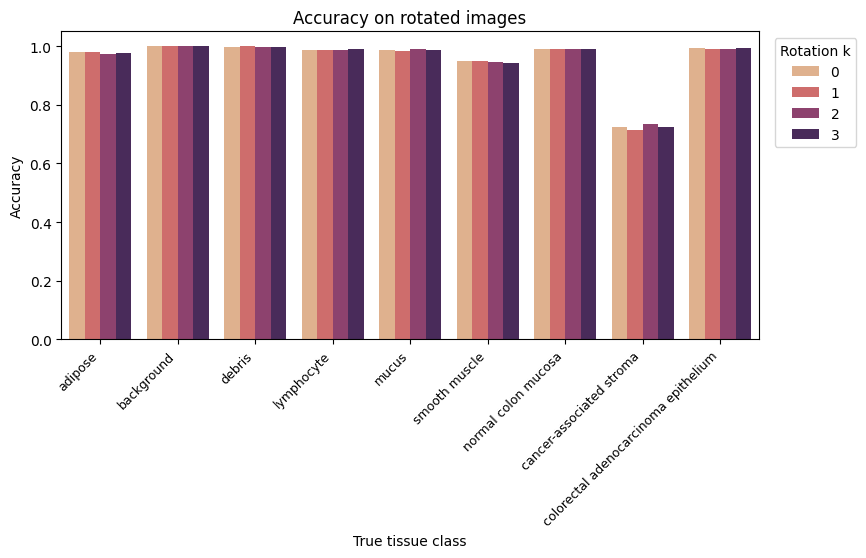

In [13]:
df['correct'] = df['true_label'] == df['predicted_label']
accuracy = df.groupby(['true_label', 'rotation'])['correct'].mean().reset_index()

pivoted = accuracy.pivot(index='true_label', columns='rotation', values='correct')
fig = plt.figure(figsize=(9, 4))
sns.barplot(data=accuracy, x='true_label', y='correct', hue='rotation', dodge=True, palette='flare')
plt.title("Accuracy on rotated images")
# map xtick to tissue labels
plt.xticks(ticks=np.arange(NUM_CLASSES), labels=[tissue_labels[i] for i in range(NUM_CLASSES)], rotation=45, ha='right', fontsize=9)
plt.ylabel("Accuracy")
plt.xlabel("True tissue class", )
plt.legend(title="Rotation k", loc='upper right', bbox_to_anchor=(1.15, 1.),)
plt.show()

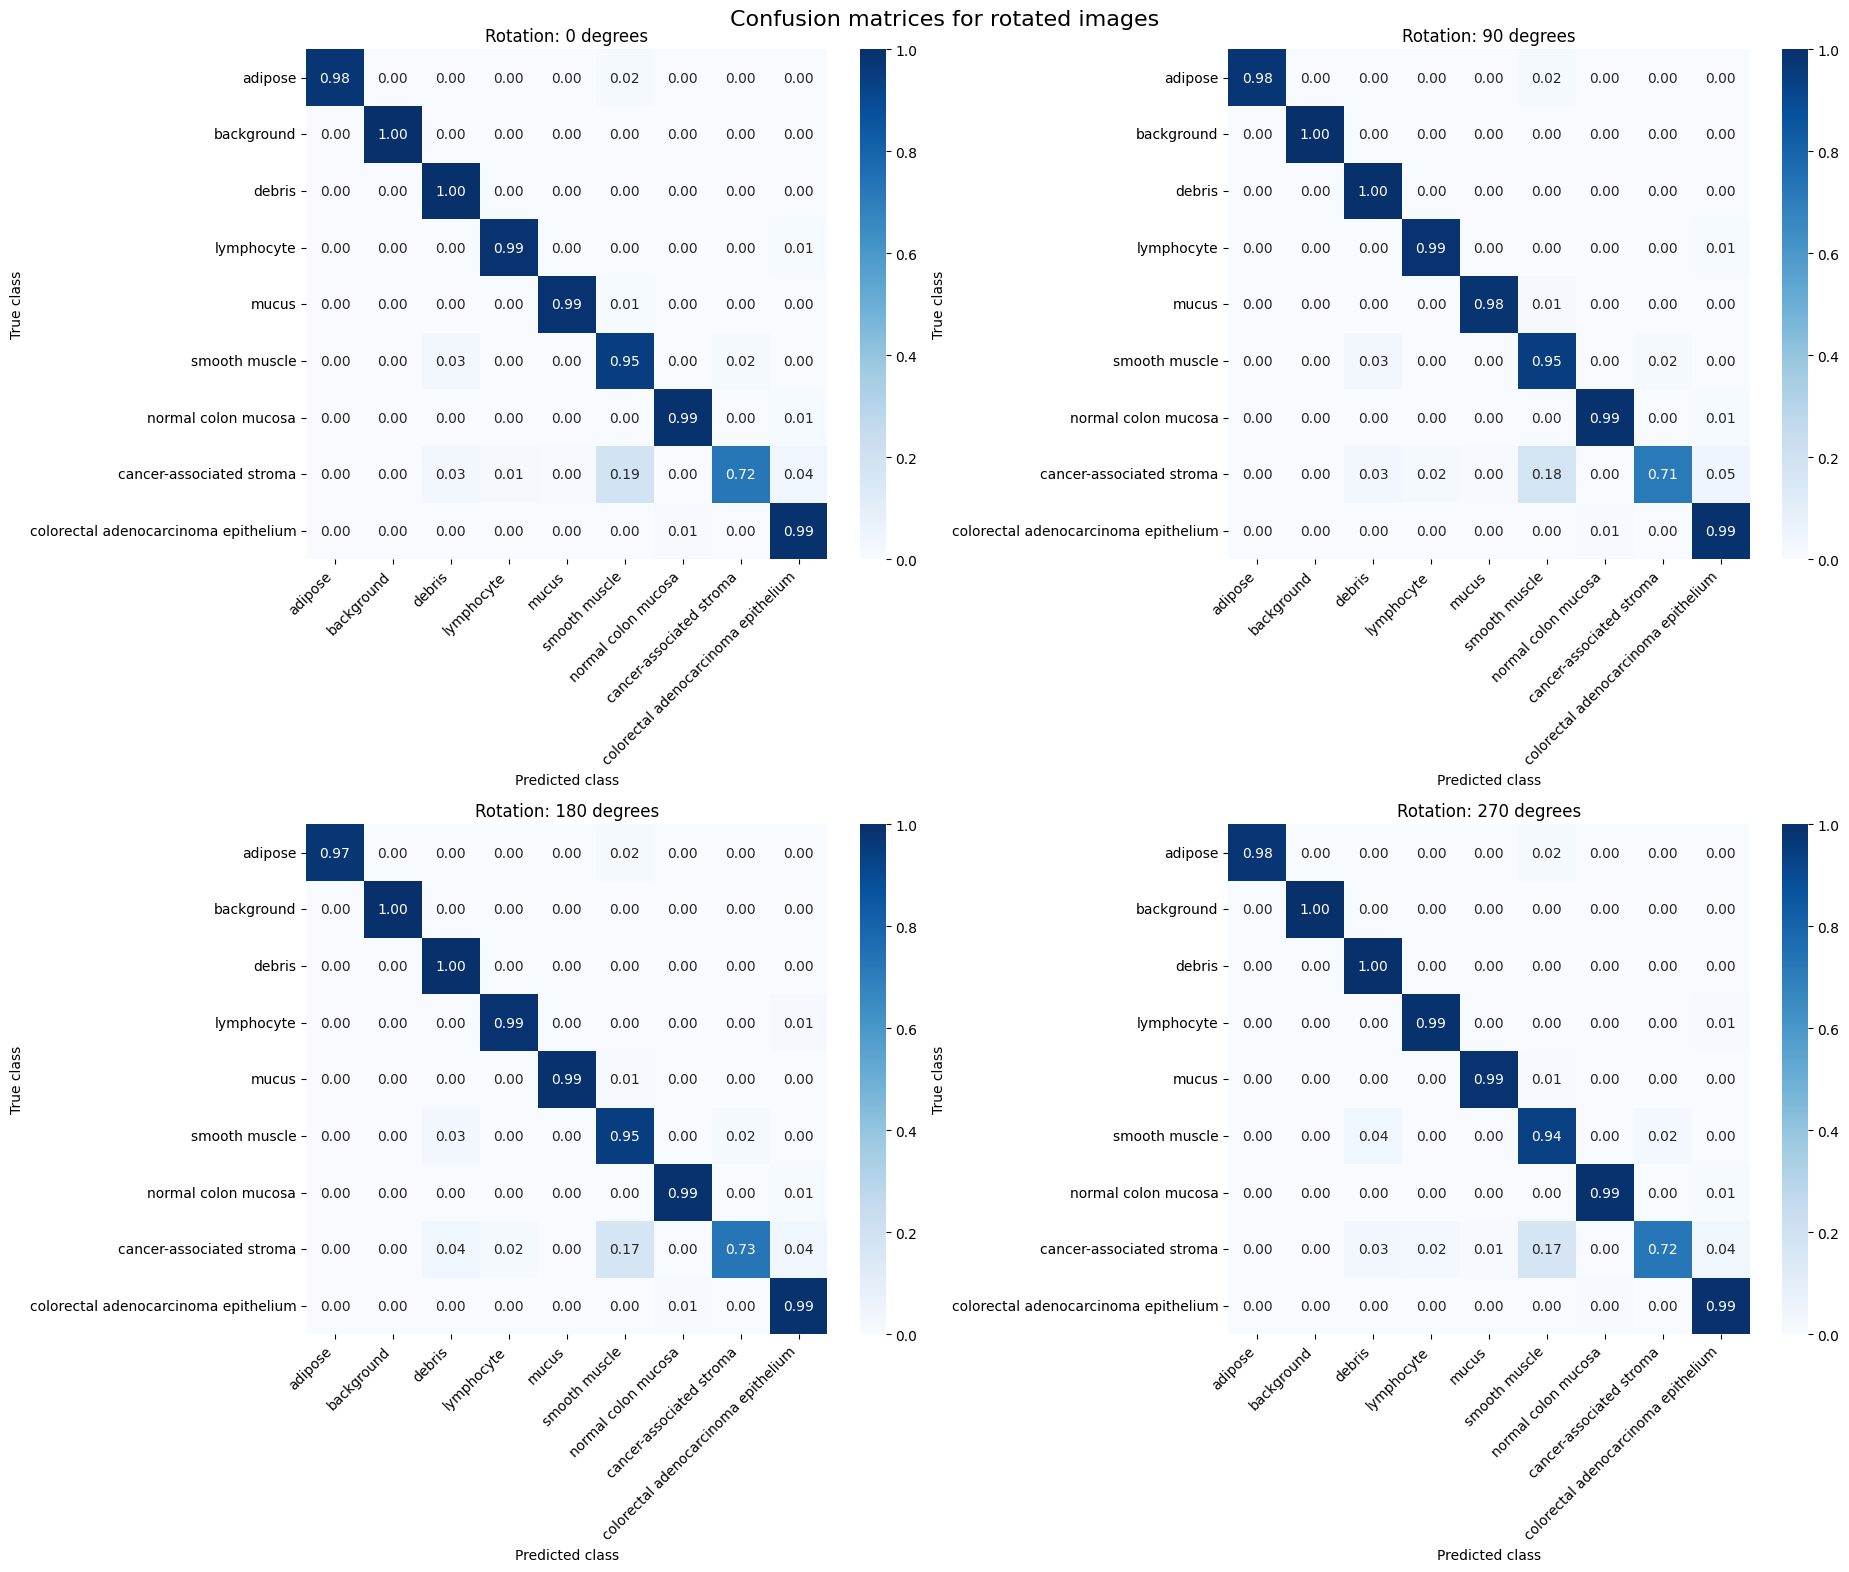

In [29]:
# plot confusion matrix

fig, axs = plt.subplots(2, 2, figsize=(19, 16))

for group in df.groupby('rotation'):
    true = group[1]['true_label']
    predicted = group[1]['predicted_label']
    cm = confusion_matrix(true, predicted, labels=list(tissue_labels.keys()), normalize='true')

    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', ax=axs[group[0] // 2, group[0] % 2])
    axs[group[0] // 2, group[0] % 2].set_title(f"Rotation: {group[0] * 90} degrees")
    axs[group[0] // 2, group[0] % 2].set_xlabel("Predicted class")
    axs[group[0] // 2, group[0] % 2].set_ylabel("True class")
    axs[group[0] // 2, group[0] % 2].set_xticklabels(tissue_labels.values(), rotation=45, ha='right')
    axs[group[0] // 2, group[0] % 2].set_yticklabels(tissue_labels.values(), rotation=0)
plt.suptitle("Confusion matrices for rotated images", fontsize=16)
plt.tight_layout()
plt.show()


## Basic explanations

In [16]:
from copy import deepcopy
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import visualization as viz

class ClassificationModule(torch.nn.Module):
    """Extract classification module from model."""

    def __init__(self, model):
        super(ClassificationModule, self).__init__()
        self.encoder = deepcopy(model.encoder)
        self.prediction_head = deepcopy(model.output_9)

    def forward(self, x):
        # x is image concatenated with segmentations
        features = self.encoder(x)['features']
        return self.prediction_head(features)
    

def get_concat_segm(image, model, device):
    """Generate concatenated segmentations with original image."""

    model.to(device)
    image = image.unsqueeze(0)
    nuclei_segmentation, cell_segmentation = model(image.to(device), return_segmentation_maps=True)
    nuclei_segmentation = nuclei_segmentation.cpu().detach()
    cell_segmentation = cell_segmentation.cpu().detach()
    x = torch.cat((nuclei_segmentation, cell_segmentation, image), dim=1)
    return x


def calc_attributions(attributor, model, device, image, target, **kwargs):
    """Calculate attributions for given image and target class using a caputm.atrr method."""
    image.requires_grad = True # image should have shape (B, C, H, W)

    model.to(device)
    model.zero_grad()
    attributor = attributor(model) # like Saliency(model) or IntegratedGradients(model)
    attributions = attributor.attribute(
        image.to(device), 
        target=target, 
        **kwargs
    )
    return attributions

In [13]:
# take the classification module and the image
classification_module = ClassificationModule(model)
classification_module.to(device)
classification_module.eval()

concat_img = get_concat_segm(test_dataset[IMG_IDX][0], model, device)
prediction = classification_module(concat_img.to(device))

print(f"Predicted class: {tissue_labels[prediction.argmax().item()]}, True class: {tissue_labels[test_dataset[IMG_IDX][1]]}")

Predicted class: colorectal adenocarcinoma epithelium, True class: colorectal adenocarcinoma epithelium


normal colon mucosa


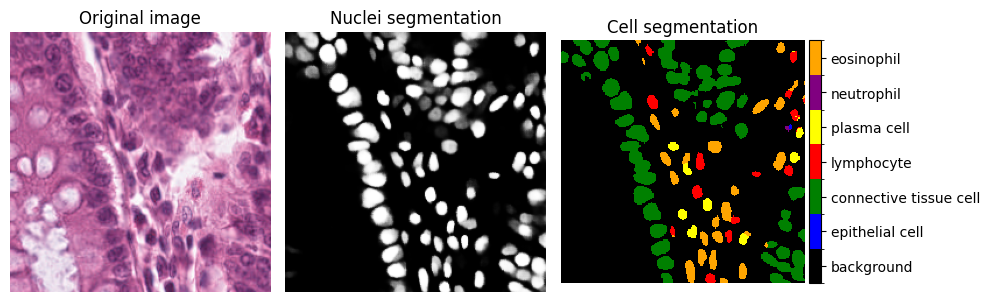

In [14]:
# Get image
IMG_IDX = 4800
image, label = test_dataset[IMG_IDX]

concat_input_image = get_concat_segm(image, model, device)

print(tissue_labels[label])
model.to(device)
plot_segmentations(image.squeeze(0).detach(), model, device, cell_labels, cell_colors)

colorectal adenocarcinoma epithelium


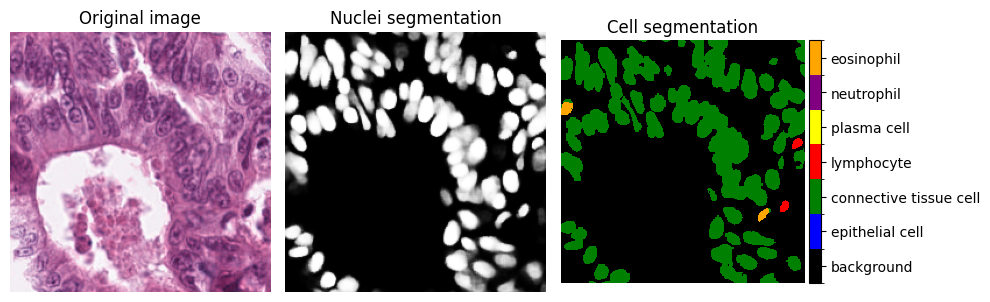

In [167]:
# Get image
IMG_IDX = 6800
image, label = test_dataset[IMG_IDX]

concat_input_image = get_concat_segm(image, model, device)

print(tissue_labels[label])
model.to(device)
plot_segmentations(image.squeeze(0).detach(), model, device, cell_labels, cell_colors)

In [17]:
# Explain with saliency map
grads = calc_attributions(attributor=Saliency, model=classification_module, device=device, image=concat_input_image, target=label)
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

# Extract the segmentations for plotting attributions on them
concat_np = concat_input_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
nucl_segmentation = concat_np[:, :, 0:1]
cell_segmentation = concat_np[:, :, 1:8]
image_np = concat_np[:, :, 8:]

nucl_attributions = grads[:, :, 0:1]
cell_attributions = grads[:, :, 1:8]
img_attributions = grads[:, :, 8:]

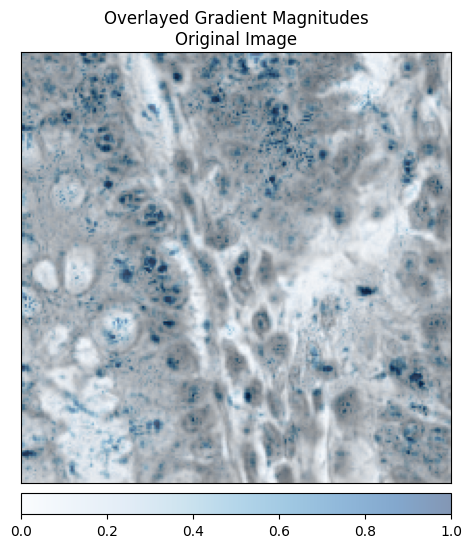

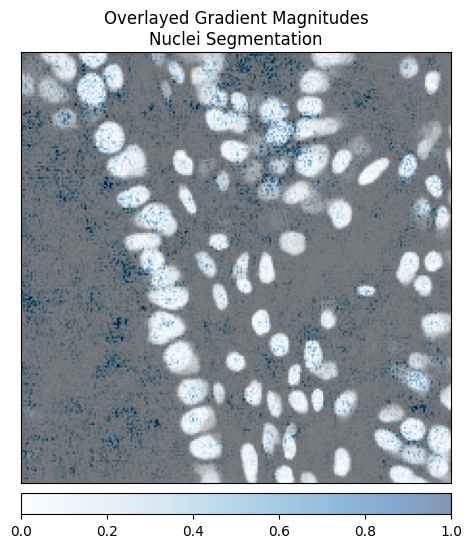

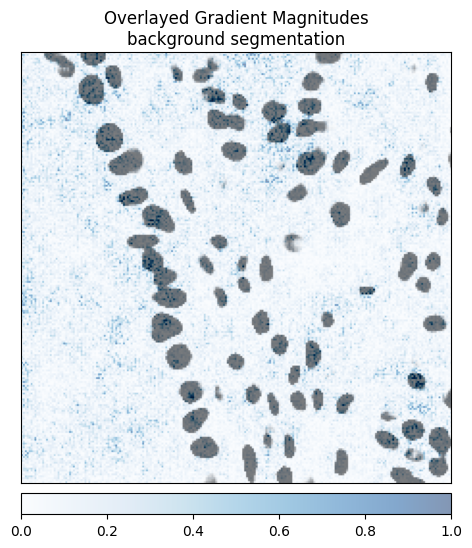

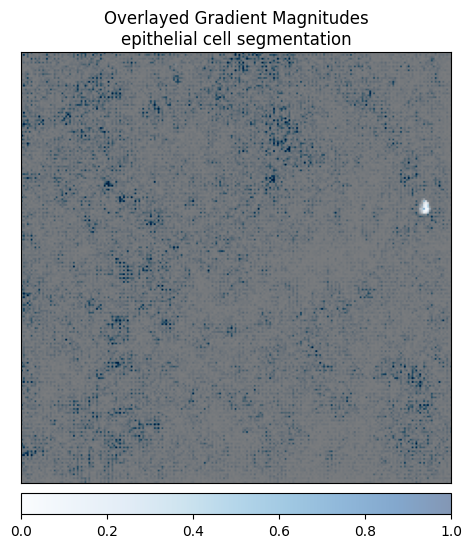

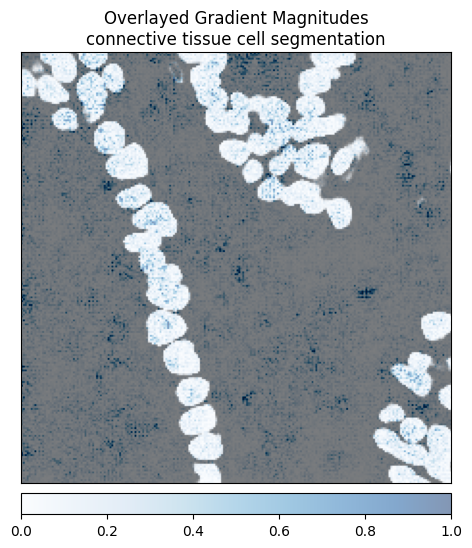

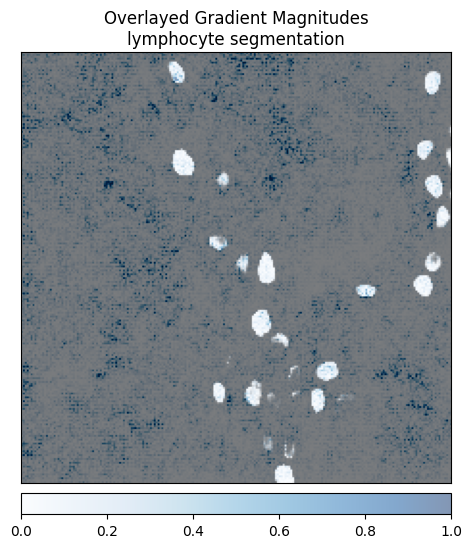

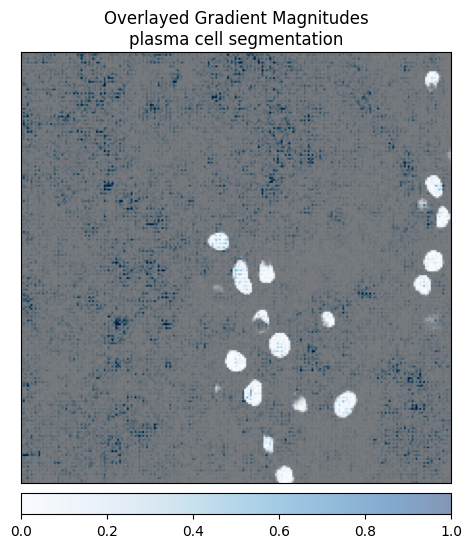

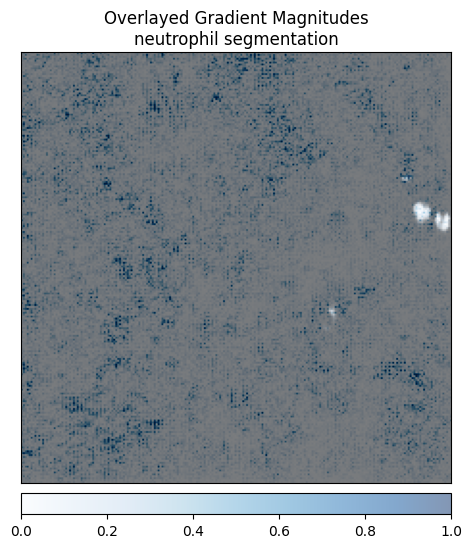

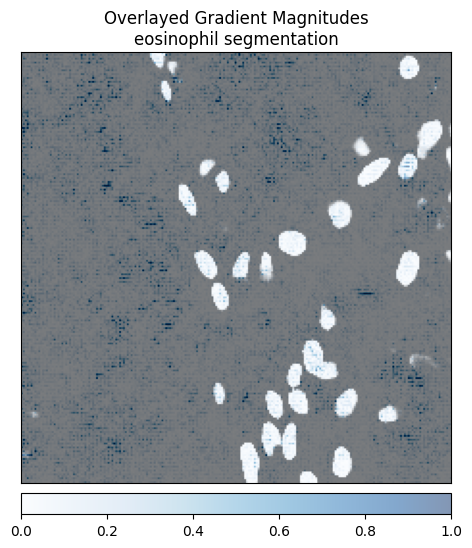

In [18]:
# Attribution in the original image
viz.visualize_image_attr(img_attributions, image_np, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes\nOriginal Image",)

# Attribution in the nuclei segmentation
viz.visualize_image_attr(nucl_attributions, nucl_segmentation, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes\nNuclei Segmentation",)

# Attribution in the cell segmentation
for i in range(7):
    viz.visualize_image_attr(cell_attributions[:, :, i:i+1], cell_segmentation[:, :, i:i+1], method="blended_heat_map", sign="absolute_value",
                             show_colorbar=True, title=f"Overlayed Gradient Magnitudes\n{cell_labels[i]} segmentation",)

In [19]:
# Integrated gradients 
ig = calc_attributions(
    attributor=IntegratedGradients, 
    model=classification_module, 
    device=torch.device('cpu'), # they are extremely memory consuming, so compute them on CPU
    image=concat_input_image, 
    target=label,
    internal_batch_size=8, # reduce internal batch size to reduce memory consumption
    )
ig = np.transpose(ig.squeeze().cpu().detach().numpy(), (1, 2, 0))

# Extract the segmentations for plotting attributions in them
nucl_attributions_ig = ig[:, :, 0:1]
cell_attributions_ig = ig[:, :, 1:8]
img_attributions_ig = ig[:, :, 8:]

# Check which part have the highest attribution
mean_parts_attributions = [
    nucl_attributions_ig.mean(),
    cell_attributions_ig.mean(),
    img_attributions_ig.mean()
]
print(mean_parts_attributions)


[4.000132265912925e-05, 8.233138778811617e-06, 4.394079542354656e-05]


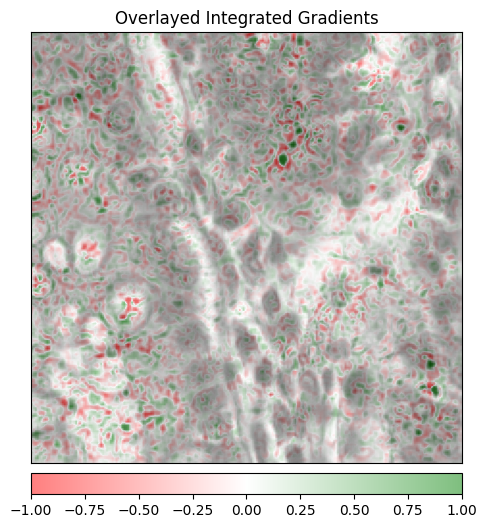

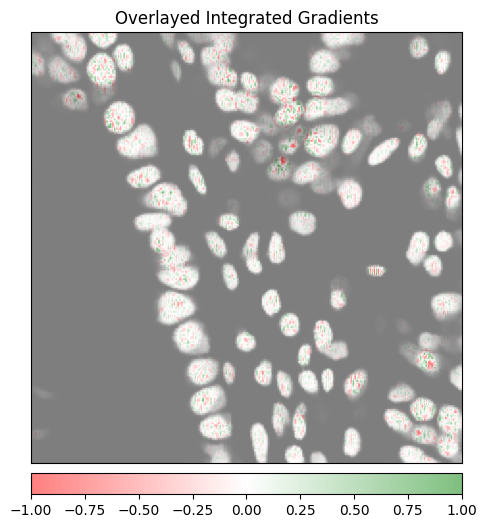

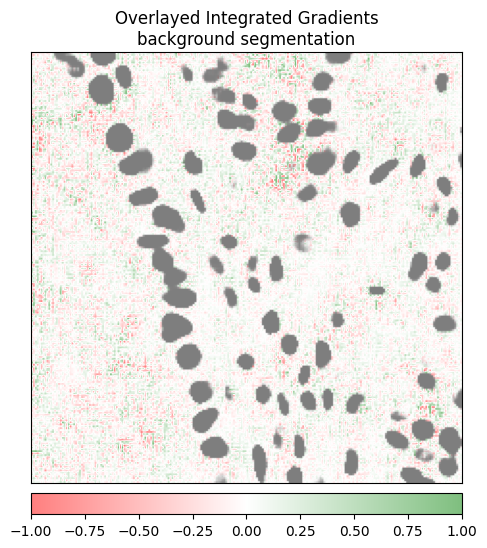

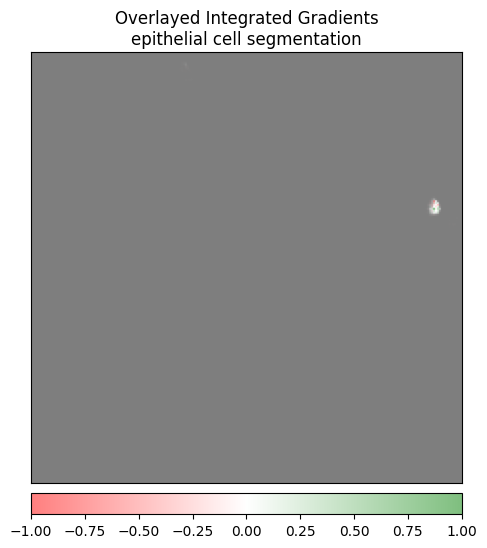

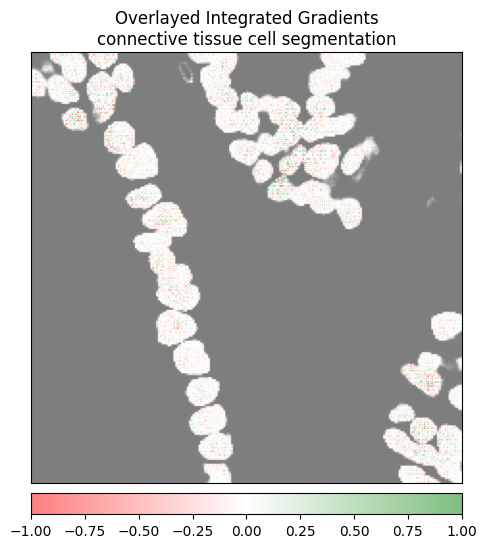

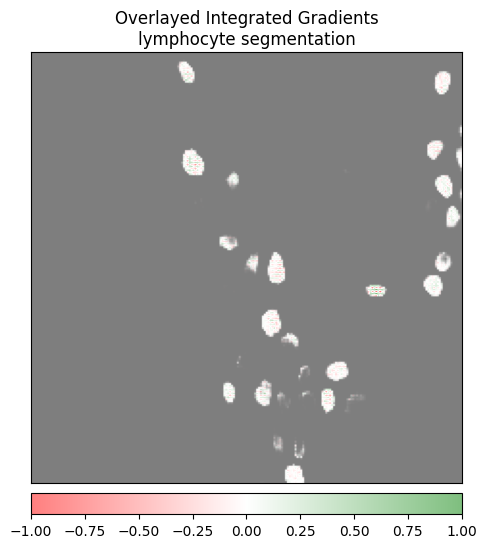

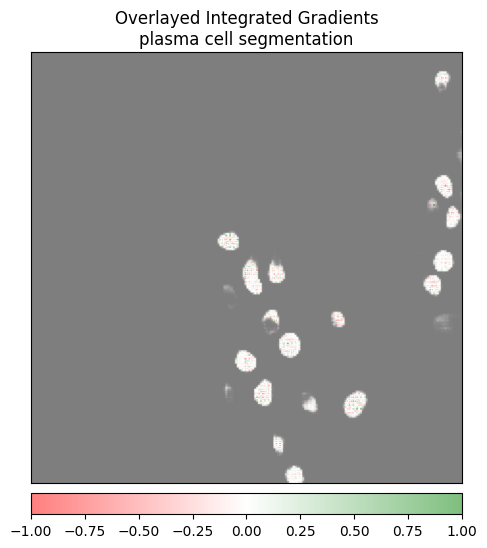

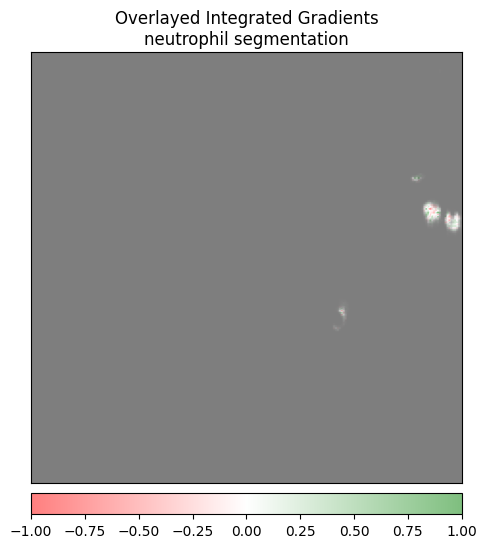

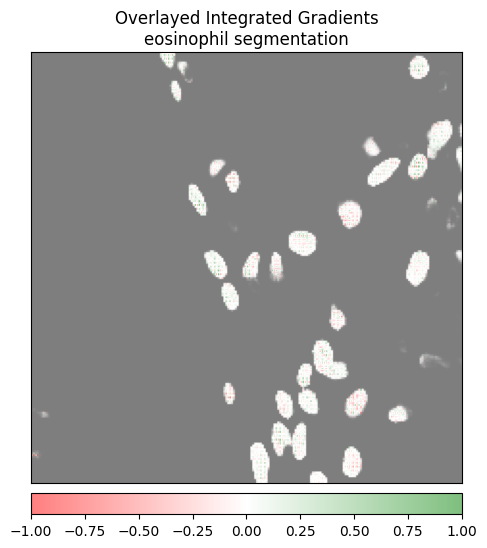

In [20]:
# Attribution in the original image
viz.visualize_image_attr(img_attributions_ig, image_np, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

# Attribution in the nuclei segmentation
viz.visualize_image_attr(nucl_attributions_ig, nucl_segmentation, method="blended_heat_map", sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

# Attribution in the cell segmentation
for i in range(7):
    viz.visualize_image_attr(cell_attributions_ig[:, :, i:i+1], cell_segmentation[:, :, i:i+1], method="blended_heat_map", sign="all",
                             show_colorbar=True, title=f"Overlayed Integrated Gradients\n{cell_labels[i]} segmentation")